## 1. Data Loading

In this notebook, we use a real-world dataset from Kaggle to demonstrate
Decision Tree models for both **classification** and **regression**.

The dataset used here is the **Wine Quality Dataset**, which contains
physicochemical properties of red wine samples and a quality score
rated by human experts.

This dataset is particularly suitable for Decision Trees because:

- All features are continuous numeric variables
- The relationship between features and wine quality is highly non-linear
- Decision Trees can naturally capture feature interactions
- Tree-based models produce interpretable, rule-based decisions


In [26]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("../../data/WineQT.csv")

df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [27]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


The dataset contains physicochemical measurements such as acidity,
residual sugar, chlorides, sulphates, alcohol content, and a target
variable `quality`, which represents the wine quality score.


In [28]:
X = df.drop(columns=["quality"]).values
y_reg = df["quality"].values

# Binary classification: good (>=6) vs bad (<6)
y_clf = (y_reg >= 6).astype(int)


We consider two tasks in this notebook:

- **Regression**: Predict the wine quality score directly.
- **Classification**: Classify wines as *good* or *bad* based on quality.

This allows us to analyze how Decision Trees behave differently under
classification and regression settings.


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_clf_train, y_clf_test = train_test_split(
    X, y_clf, test_size=0.3, random_state=42
)

_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.3, random_state=42
)


## 2. Algorithm Introduction – Decision Trees

Decision Trees are non-parametric, tree-based models that perform prediction
by recursively partitioning the feature space into smaller, more homogeneous
regions.

Unlike linear models, Decision Trees do not assume any specific functional
form between the input features and the target variable. Instead, they learn
a set of **if–then rules** that split the data based on feature thresholds.


### 2.1 Tree Structure

A Decision Tree consists of three main components:

- **Root Node**: Represents the entire dataset.
- **Internal Nodes**: Each internal node corresponds to a decision rule
  of the form  
  
  $$\large x_j \le t$$
  
  where $\large x_j$ is a feature and $\large t$ is a threshold.
- **Leaf Nodes**: Terminal nodes that store the final prediction.

For a new data point, prediction is made by starting at the root node and
following the decision rules until a leaf node is reached.

### 2.2 Splitting Criterion for Classification

For classification problems, Decision Trees aim to create child nodes
that are as *pure* as possible.

Two common impurity measures are:


#### Gini Impurity

The Gini impurity of a node is defined as:
  

$$
\large G = 1 - \sum_{k=1}^{K} p_k^2
$$


where $\large p_k$ is the proportion of samples belonging to class $\large k$

in the node.

- $\large G = 0$ indicates a perfectly pure node.

- Higher values indicate more mixed class distributions.


#### Entropy

Entropy measures the uncertainty in class labels:

$$\large H = - \sum_{k=1}^{K} p_k \log_2(p_k)$$

Lower entropy indicates higher purity.
The Information Gain of a split is defined as the reduction in entropy
after the split.

At each node, the Decision Tree evaluates all possible splits and selects
the one that maximizes impurity reduction.


### 2.3 Splitting Criterion for Regression

For regression tasks, Decision Trees aim to reduce the variability of the
target values within each node.

The most common criterion is **Mean Squared Error (MSE)**:

$$\large \mathrm{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \bar{y} \right)^2$$
At each split, the algorithm chooses the feature and threshold that minimize
the weighted average MSE of the left and right child nodes.


### 2.4 Prediction at Leaf Nodes

A key characteristic of Decision Trees is how predictions are made at
leaf nodes:

- **Classification**:  
  The predicted class is the majority class in the leaf.
  Predicted probabilities correspond to the class proportions.

- **Regression**:  
  The predicted value is the **mean** of the target values in the leaf.


### 2.5 Why Decision Tree Regression Produces Piecewise Constant Predictions

Unlike linear regression, Decision Tree regression does **not interpolate**
between data points.

Because each leaf node predicts a single constant value (the mean of
training samples in that leaf), the resulting prediction function is
**piecewise constant**.

This explains why, even on the training data, a Decision Tree regressor
may not exactly reproduce the original target values unless the tree is
grown very deep.

This behavior was also observed in our unit tests, where multiple data
points falling into the same leaf received identical predictions.


### 2.6 Advantages and Limitations

**Advantages**
- Can model complex non-linear relationships
- Requires little data preprocessing (no feature scaling)
- Highly interpretable decision rules
- Naturally captures feature interactions

**Limitations**
- Prone to overfitting if grown too deep
- Predictions can be unstable with respect to small data changes
- Axis-aligned splits may be suboptimal for some problems


## 3. Decision Tree Classification Example

We first demonstrate Decision Trees on a **binary classification task**
using the Wine Quality dataset.

The goal is to classify wines as:
- **Good wine**: quality ≥ 6
- **Bad wine**: quality < 6

This binary setup allows us to clearly observe how Decision Trees split
the feature space and how model complexity affects performance.


In [30]:
from rice_ml.decision_trees import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Train a basic decision tree classifier
clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
    random_state=42,
)

clf.fit(X_train, y_clf_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_clf_train, y_train_pred)
test_acc = accuracy_score(y_clf_test, y_test_pred)

train_acc, test_acc


(0.74875, 0.6909620991253644)

The training and testing accuracies provide an initial assessment of
the model's performance.

- A higher training accuracy indicates the tree is able to fit the data.
- The gap between training and testing accuracy reflects the model's
  generalization ability.

At moderate depth, Decision Trees often achieve good performance without
severe overfitting.


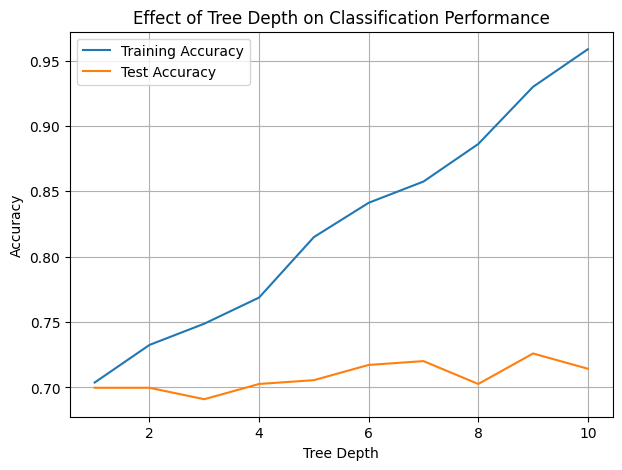

In [31]:
depths = range(1, 11)
train_accs = []
test_accs = []

for d in depths:
    clf = DecisionTreeClassifier(
        criterion="gini",
        max_depth=d,
        random_state=42,
    )
    clf.fit(X_train, y_clf_train)

    train_accs.append(
        accuracy_score(y_clf_train, clf.predict(X_train))
    )
    test_accs.append(
        accuracy_score(y_clf_test, clf.predict(X_test))
    )

    import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(depths, train_accs, label="Training Accuracy")
plt.plot(depths, test_accs, label="Test Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Effect of Tree Depth on Classification Performance")
plt.legend()
plt.grid(True)
plt.show()



The results illustrate the classic **bias–variance tradeoff**:

- **Shallow trees** (small max_depth) have high bias and may underfit
  the data.
- **Deeper trees** can capture complex patterns but may overfit,
  resulting in high training accuracy and reduced test accuracy.

This behavior highlights the importance of controlling tree complexity
through hyperparameters such as `max_depth`.

feature_importances = pd.Series(
    clf.feature_importances_,
    index=df.drop(columns=["quality"]).columns
).sort_values(ascending=False)

feature_importances

Feature importance values indicate how much each feature contributes to
reducing impurity across the tree.

Higher values suggest that a feature plays a more significant role in
the decision-making process.


## 4. Decision Tree Regression Example

We now demonstrate Decision Trees on a **regression task** using the same
Wine Quality dataset.

The goal is to predict the **wine quality score** directly as a continuous
variable.

This example highlights a key characteristic of Decision Tree regression:
**piecewise constant predictions**, which differ fundamentally from
linear regression models.


In [32]:
from rice_ml.decision_trees import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train a basic decision tree regressor
reg = DecisionTreeRegressor(
    criterion="mse",
    max_depth=3,
    random_state=42,
)

reg.fit(X_train, y_reg_train)

# Predictions
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Evaluation metrics
train_mse = mean_squared_error(y_reg_train, y_train_pred)
test_mse = mean_squared_error(y_reg_test, y_test_pred)

train_mae = mean_absolute_error(y_reg_train, y_train_pred)
test_mae = mean_absolute_error(y_reg_test, y_test_pred)

train_mse, test_mse, train_mae, test_mae


(0.42146748461864403,
 0.4770403410721603,
 0.5097980201419197,
 0.5605314120092804)

The regression performance is evaluated using Mean Squared Error (MSE)
and Mean Absolute Error (MAE).

- Lower training error indicates the tree fits the training data well.
- Higher test error suggests limited generalization when the tree becomes
  overly complex.

Unlike linear regression, Decision Trees approximate the target function
using constant values within each leaf node.


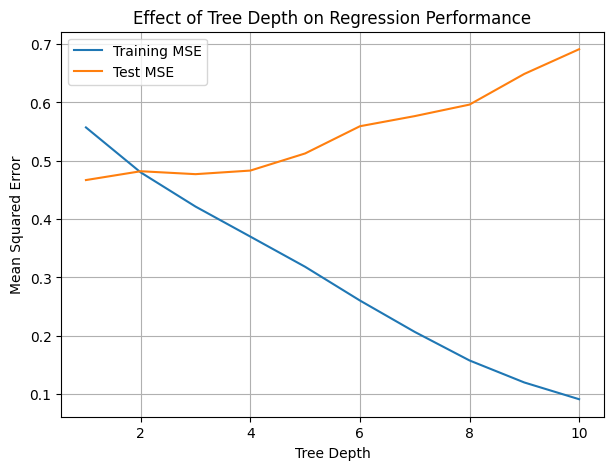

In [33]:
depths = range(1, 11)
train_mse_list = []
test_mse_list = []

for d in depths:
    reg = DecisionTreeRegressor(
        criterion="mse",
        max_depth=d,
        random_state=42,
    )
    reg.fit(X_train, y_reg_train)

    train_mse_list.append(
        mean_squared_error(y_reg_train, reg.predict(X_train))
    )
    test_mse_list.append(
        mean_squared_error(y_reg_test, reg.predict(X_test))
    )

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(depths, train_mse_list, label="Training MSE")
plt.plot(depths, test_mse_list, label="Test MSE")
plt.xlabel("Tree Depth")
plt.ylabel("Mean Squared Error")
plt.title("Effect of Tree Depth on Regression Performance")
plt.legend()
plt.grid(True)
plt.show()


As tree depth increases, training error consistently decreases because
the model becomes more expressive.

However, test error does not necessarily decrease monotonically. Beyond
a certain depth, the tree begins to overfit the training data.

This behavior reflects the **piecewise constant nature** of Decision Tree
regression:
- Each leaf node predicts a single constant value.
- Increasing depth creates more, smaller regions with different constants.
- Excessive depth leads to memorization rather than generalization.

This phenomenon was also observed in our unit tests, where multiple data
points falling into the same leaf received identical predictions.

Compared to linear regression, Decision Tree regression:

- Can capture non-linear relationships without feature engineering
- Does not extrapolate beyond observed target values
- Produces step-like prediction functions rather than smooth curves

These properties make Decision Trees powerful but potentially unstable
when used without proper regularization.


## 5. Summary & Key Takeaways

In this notebook, we explored Decision Tree models for both classification
and regression tasks using the Wine Quality dataset.

The key observations and insights are summarized below.

### 5.1 Model Behavior

- Decision Trees partition the feature space using **axis-aligned splits**,
  resulting in a hierarchical, rule-based decision structure.
- Unlike linear models, Decision Trees make **no assumptions** about the
  functional relationship between features and the target variable.
- For regression, predictions are **piecewise constant**, as each leaf
  node outputs the mean target value of the samples it contains.

### 5.2 Effect of Model Complexity

- Increasing tree depth reduces training error monotonically, as deeper
  trees can better fit the training data.
- Test performance, however, follows a non-monotonic trend:
  - Shallow trees underfit the data.
  - Very deep trees overfit and generalize poorly.
- This behavior clearly demonstrates the **bias–variance tradeoff** in
  Decision Tree models.

### 5.3 Classification vs Regression

- In classification tasks, Decision Trees aim to maximize node purity
  using criteria such as Gini impurity or entropy.
- In regression tasks, the objective is to minimize prediction error,
  typically measured by Mean Squared Error (MSE).
- Despite different objectives, both tasks rely on the same recursive
  partitioning mechanism.

### 5.4 Practical Implications

- Tree depth (`max_depth`) is one of the most important hyperparameters and
  must be carefully tuned to balance bias and variance.
- Additional regularization parameters, such as `min_samples_leaf`, can
  further improve generalization performance.
- While single Decision Trees are interpretable, they can be unstable;
  ensemble methods such as **Random Forests** mitigate this issue by
  averaging over multiple trees.

### 5.5 Final Remarks

Decision Trees provide a powerful and intuitive approach to modeling
non-linear relationships in real-world datasets.

Their interpretability and flexibility make them a strong baseline model
and a foundation for more advanced ensemble techniques explored in
subsequent sections.
